# Azure OpenAI Assistants - Code Interpreter

This notebook will find answers to a data set:
1. If 1 row in the dataset is 1 sighthing, what's our total sightings?
2. Which state has the most sightings?
3. Which season has the most sightings?
4. What are the top 10 years with the most sightings?
5. How many sightings did we have for Washington state in the year 2000?

Answers:
1. 5021
2. Washington (601)
3. Summer
4. 2004, 2005, 2006, 2003, 2000, 2007, 2008, 2012, 2001, 2011
5. 28

## Install Dependencies

In [ ]:
%pip install openai

## Load Azure Configuration

In [1]:
from dotenv import load_dotenv
import os

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_openai_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

## Step 1-2:
1. Create an Assistant
2. Create a Thread

In [2]:
from openai import AzureOpenAI
import time

# Create an AzureOpenAI client
client = AzureOpenAI(
  azure_endpoint = azure_openai_endpoint,
  api_key= azure_openai_key,
  api_version=azure_openai_api_version
)

# Create a file
file = client.files.create(
  file=open("../Data/assistant/bigfootsightings.csv", "rb"),
  purpose='assistants'
)

# STEP 1: Create an assistant
assistant = client.beta.assistants.create(
  model=azure_openai_deployment,
  name="bigfootsightings",
  instructions="""You are an assistant answering questions about bigfootsightings dataset.""",
  tools=[{"type":"code_interpreter"}],
  tool_resources={"code_interpreter":{"file_ids":[file.id]}},
  temperature=1,
  top_p=1, 
)

# STEP 2: Create a thread
thread = client.beta.threads.create()


## Step 3-6: 
3. Add a message to the thread
4. Run the Assistant
5. Check the Run Status
6. Display the Assistant's Response

In [3]:
PROMPT_SUFFIX = """
- **ALWAYS** before giving the Final Answer, try another method.
Then reflect on the answers of the two methods you did and ask yourself
if it answers correctly the original question.
If you are not sure, try another method.
- If the methods tried do not give the same result,reflect and
try again until you have two methods that have the same result.
- If you still cannot arrive to a consistent result, say that
you are not sure of the answer.
- If you are sure of the correct answer, create a beautiful
and thorough response using Markdown.
- **DO NOT MAKE UP AN ANSWER OR USE PRIOR KNOWLEDGE,
ONLY USE THE RESULTS OF THE CALCULATIONS YOU HAVE DONE**.
- **ALWAYS**, as part of your "Final Answer", explain how you got
to the answer on a section that starts with: "\n\nExplanation:\n".
In the explanation, mention the column names that you used to get
to the final answer and provide the python code you used.

"""

user_question ="""If 1 row in the dataset is 1 sighting, what's our total sightings
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
value = content_block.text.value
print(value)


SyncCursorPage[Message](data=[Message(id='msg_W13LTn6bpj1jE9onPCJWrjpu', assistant_id='asst_WioDVLfmbJQ1f0fZguIooqzD', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='### Explanation:\nTo find the total number of Bigfoot sightings in the dataset, I employed two methods:\n\n1. Using the `shape` attribute of the pandas DataFrame, which returns a tuple representing the dimensionality of the DataFrame. The first element of the tuple represents the number of rows.\n2. Using the `len()` function on the DataFrame, which returns the length of the DataFrame, equivalent to the number of rows.\n\nBoth methods returned the same result, confirming the consistency of the answer:\n\n- **Total Sightings:** 5021\n\n**Python code used:**\n```python\n# Method 1: Using the shape attribute to find the number of rows\ntotal_sightings_method_1 = df.shape[0]\n\n# Method 2: Using the len() function to find the number of rows\ntotal_sightings_method_2 = len(df)\n```

## Step 7: Appending Messages to the thread

In [4]:
user_question ="""Which state has the most sightings? Provide the number of sightings in that state
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
value = content_block.text.value
print(value)

SyncCursorPage[Message](data=[Message(id='msg_Kh9kIYiB8NnLw5GqW7uRyd5L', assistant_id='asst_WioDVLfmbJQ1f0fZguIooqzD', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value="### Explanation:\nTo find the state with the most Bigfoot sightings, I employed two methods:\n\n1. Using the `value_counts()` function on the 'state' column to count the number of sightings per state and then using `idxmax()` to find the state with the highest count.\n2. Using the `groupby()` function to group by the 'state' column and then using the `size()` function to count the sightings per state, followed by `idxmax()` to find the state with the highest count.\n\nBoth methods returned the same result, confirming the consistency of the answer:\n\n- **State with the Most Sightings:** Washington\n- **Number of Sightings in that State:** 601\n\n**Python code used:**\n```python\n# Method 1: Using the value_counts() function to find the state with the most sightings\nstate_sigh

In [5]:
user_question ="""Which season has the most sightings?
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
value = content_block.text.value
print(value)

SyncCursorPage[Message](data=[Message(id='msg_TkEObBJcMhWWBRxZE5beGCBK', assistant_id='asst_WioDVLfmbJQ1f0fZguIooqzD', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value="### Explanation:\nTo determine which season has the most Bigfoot sightings, I used two methods:\n\n1. Using the `value_counts()` function on the 'season' column to count the number of sightings per season and then using `idxmax()` to find the season with the highest count.\n2. Using the `groupby()` function to group by the 'season' column and then using the `size()` function to count the sightings per season, followed by `idxmax()` to find the season with the highest count.\n\nBoth methods yielded the same result, confirming the consistency of the answer:\n\n- **Season with the Most Sightings:** Summer\n- **Number of Sightings in that Season:** 1867\n\n**Python code used:**\n```python\n# Method 1: Using the value_counts() function to find the season with the most sightings\nse

In [6]:
user_question ="""
What are the top 10 years with the most sightings? 
Use the date column and get the year there.
Create a bar chart with the sightings in the Y-axis and years in the X-axis and save it to a file named top10.png.
Put the value on top of each bar
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
#value = content_block.text.value
#print(value)

SyncCursorPage[Message](data=[Message(id='msg_Gxrg67zUVcwQjM5b5jlNRqOi', assistant_id='asst_WioDVLfmbJQ1f0fZguIooqzD', attachments=[Attachment(file_id='assistant-sOUb6umHX6oJTdvYueWYmpXg', tools=[CodeInterpreterTool(type='code_interpreter')])], completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='assistant-Cd9Sciz2QCNvPavlM2ufugcw', detail=None), type='image_file'), TextContentBlock(text=Text(annotations=[FilePathAnnotation(end_index=2273, file_path=FilePath(file_id='assistant-sOUb6umHX6oJTdvYueWYmpXg'), start_index=2246, text='sandbox:/mnt/data/top10.png', type='file_path')], value="### Explanation:\nTo find the top 10 years with the most Bigfoot sightings and create a bar chart, I converted the 'date' column to datetime format and extracted the year. I used two methods:\n\n1. Using the `value_counts()` function on the 'year' column to count the number of sightings per year, then using `nlargest(10)` to find the top 10 years with the highest counts, and sort

### Retrieve image output

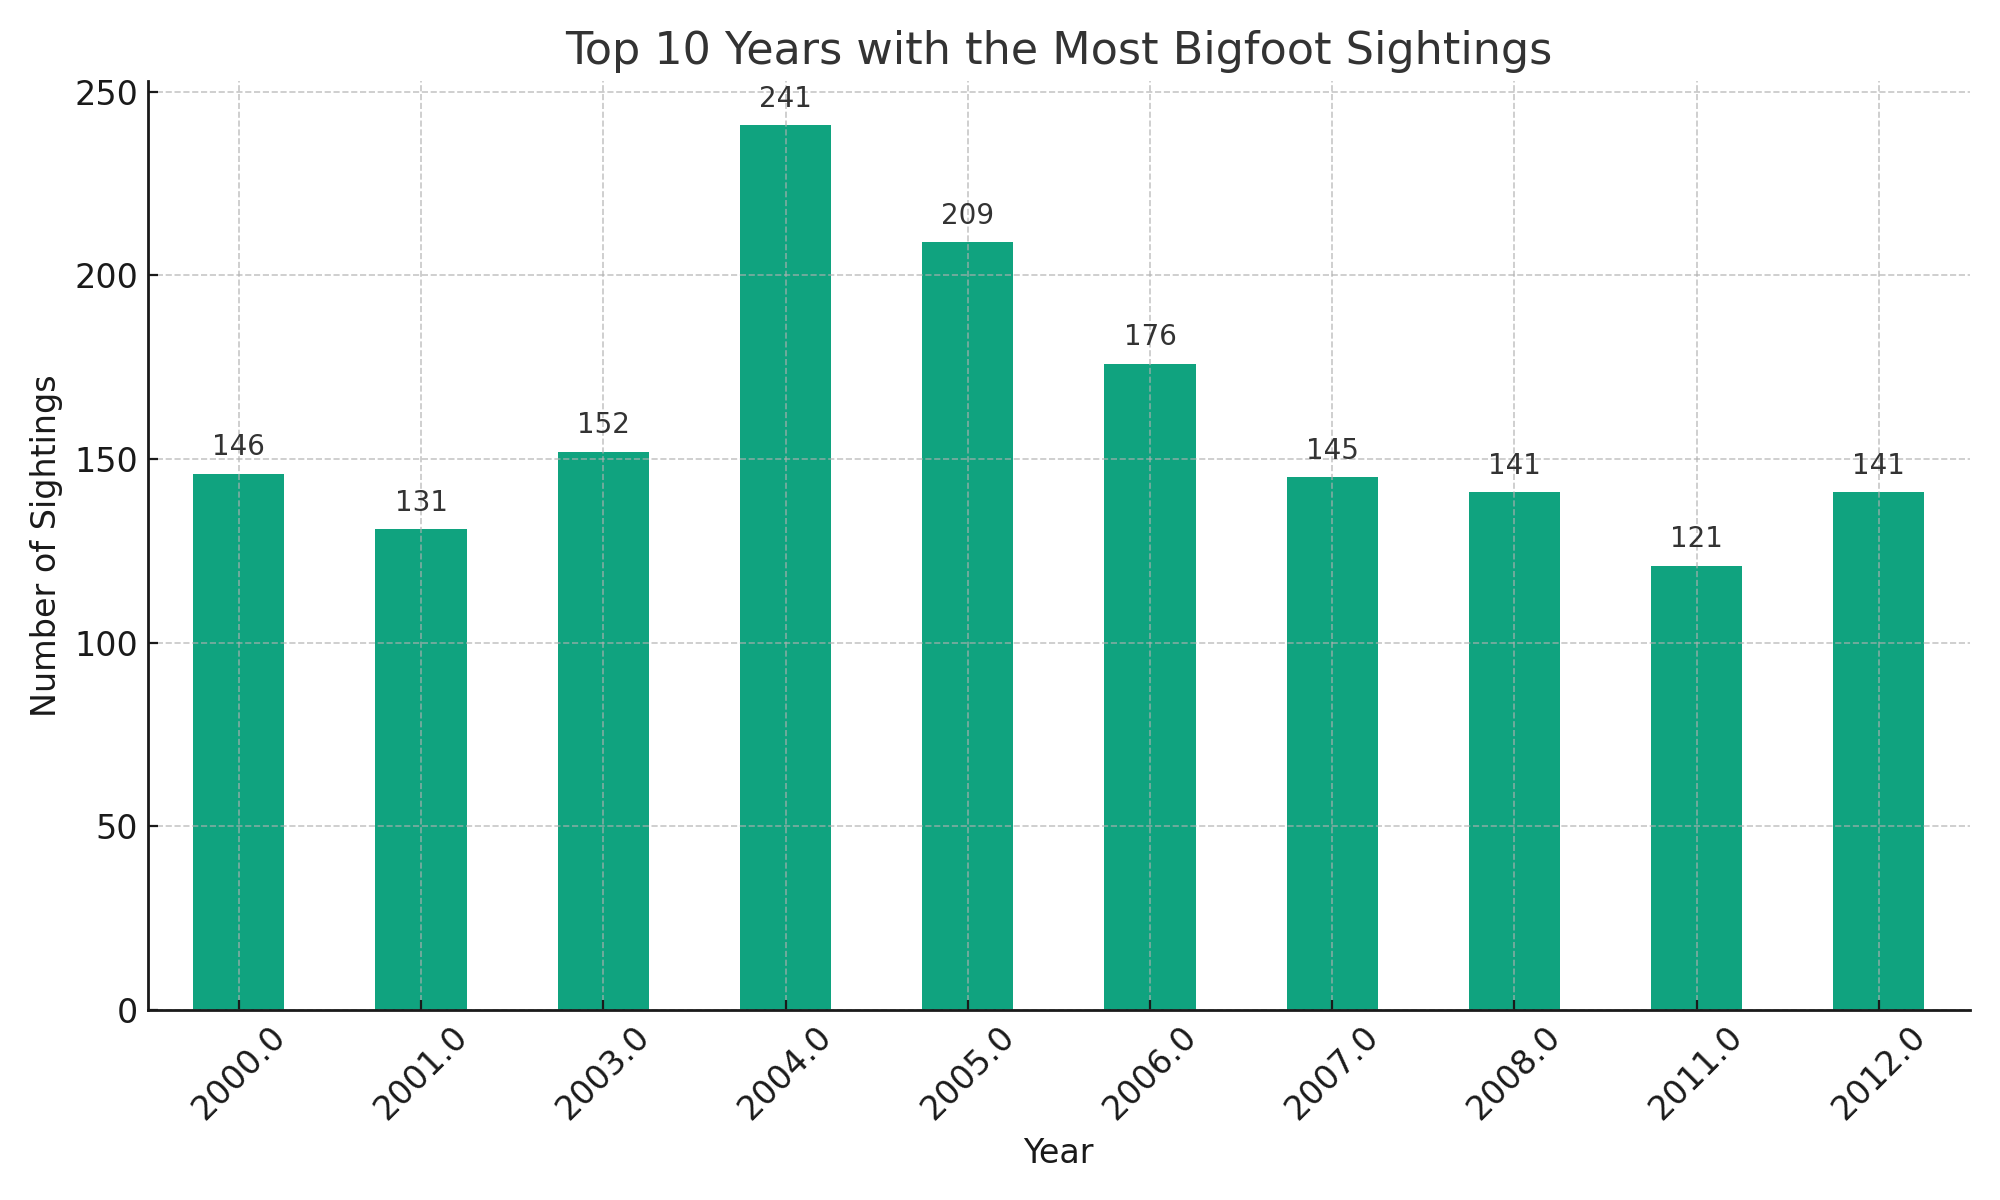

In [7]:
from PIL import Image
# enter the file_id inside content example: "assistant-fYrZ85PwbViKU9mrVoE8dqBO"
image_data = client.files.content("assistant-sOUb6umHX6oJTdvYueWYmpXg")
image= image_data.write_to_file("top10.png")

# Display the image in the default image viewer
image = Image.open("top10.png")
image.show()

In [8]:
user_question ="""How many sightings did we have for Washington state in the year 2000?
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
value = content_block.text.value
print(value)

SyncCursorPage[Message](data=[Message(id='msg_itnUjcPFWGlVfmEJRL7qsSyN', assistant_id='asst_WioDVLfmbJQ1f0fZguIooqzD', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value="### Explanation:\nTo determine the number of sightings in Washington state in the year 2000, I used two methods:\n\n1. Filtering the DataFrame for rows where the 'state' column is 'Washington' and the 'year' column is 2000, and then using the `shape` attribute to count the number of rows.\n2. Filtering the DataFrame for rows where the 'state' column is 'Washington' and the 'year' column is 2000, and then using the `len()` function to count the number of rows.\n\nBoth methods yielded the same result, confirming the consistency of the answer:\n\n- **Number of Sightings in Washington State in 2000:** 28\n\n**Python code used:**\n```python\n# Method 1: Filter the dataframe for Washington state in the year 2000 and count the number of sightings\nwa_2000_sightings_method_1 = df[(df[

In [16]:
user_question ="""Using the "observed" column, are there any sightings observed at Mt. Mitchell?
"""

# STEP 3: Add a user question to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=PROMPT_SUFFIX + user_question
)

# STEP 4: Run the thread
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# STEP 5: Check the run status
# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  time.sleep(1)
  run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
  )
if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
elif run.status == 'requires_action':
  # the assistant requires calling some functions
  # and submit the tool outputs back to the run
  pass
else:
  print(run.status)

# STEP 6: Display the Assistant's Response
content_block = messages.data[0].content[0]
value = content_block.text.value
print(value)

SyncCursorPage[Message](data=[Message(id='msg_2KUhhVsxUF3ltNpjH8tCkt4i', assistant_id='asst_wT83rcvLcpQeIrKNFZztwQJ0', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='There is **1 sighting** observed at Mt. Mitchell.\n\n### Explanation:\nTo determine if there are any sightings recorded at Mt. Mitchell using the "observed" column, I performed the following steps:\n\n1. **Filtered Observations**: I searched the `observed` column for entries that contain the phrase "Mt. Mitchell". This was done using the `str.contains()` method in Pandas, which allows for string matching within a Series.\n\n2. **Counted Results**: I counted the number of sightings that matched this filtering criteria.\n\nHere is the Python code used for this analysis:\n```python\nmt_mitchell_sightings = data[data[\'observed\'].str.contains("Mt. Mitchell", na=False)]\nnumber_of_sightings = len(mt_mitchell_sightings)\n```\n\nThe result confirms that there is indeed **1 sighting*

## Delete Assistant

In [17]:
response = client.beta.assistants.delete(assistant.id)